In [1]:
import pandas as pd

# Load train and test datasets
df = pd.read_csv("TRAIN.csv")          # Training data
test_df = pd.read_csv("TEST_FINAL.csv")  # Test data (for final predictions)

# Show basic info
print("Train shape:", df.shape)
print("Test shape:", test_df.shape)
df.head()


Train shape: (188340, 10)
Test shape: (22265, 8)


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [2]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract useful date features
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek

test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day
test_df['Weekday'] = test_df['Date'].dt.dayofweek


## Exploratory Data Analysis (EDA)

These visualizations help us understand how different features like holidays, store types, and locations affect sales.


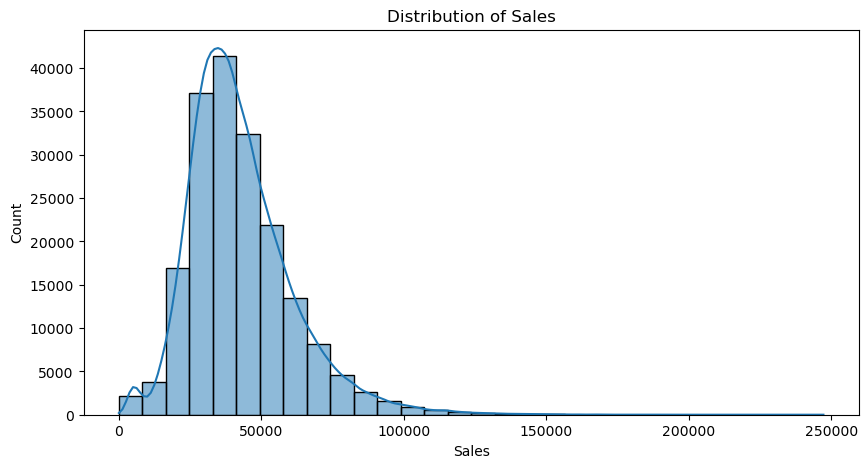

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sales distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["Sales"], kde=True, bins=30)
plt.title("Distribution of Sales")
plt.show()

**This plot shows the distribution of daily sales.**  
Sales appear to be right-skewed, with most sales concentrated in the lower range and a few high sales days.


<function matplotlib.pyplot.show(close=None, block=None)>

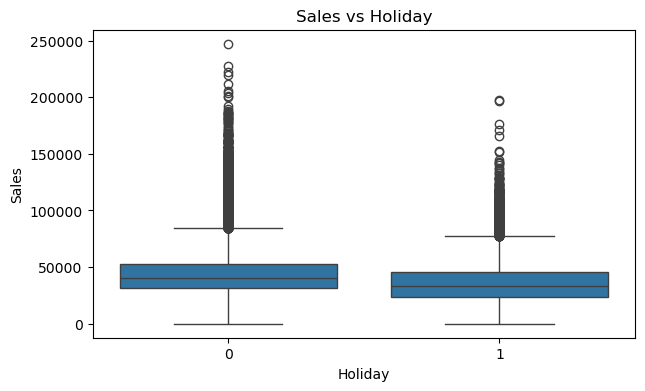

In [6]:
# Boxplot: Sales by Holiday
plt.figure(figsize=(7, 4))
sns.boxplot(x="Holiday", y="Sales", data=df)
plt.title("Sales vs Holiday")
plt.show

**This boxplot compares sales between holidays and non-holidays.**  
It seems that holidays may have a higher median and more outliers, suggesting they could affect sales.


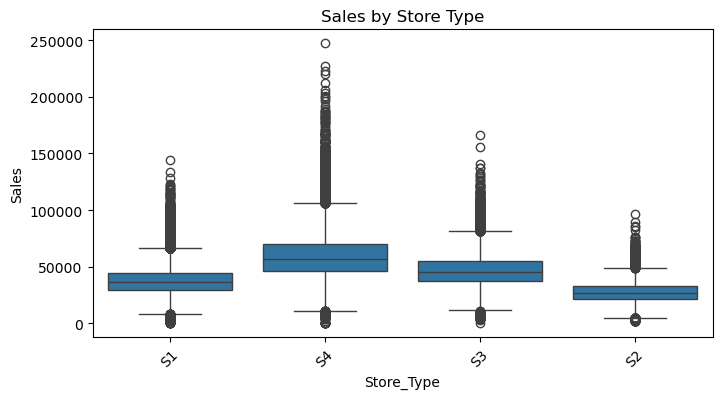

In [8]:
# Boxplot: Sales by Store Type
plt.figure(figsize=(8, 4))
sns.boxplot(x="Store_Type", y="Sales", data=df)
plt.title("Sales by Store Type")
plt.xticks(rotation=45)
plt.show()


**This plot shows how different Store Types impact sales.**  
Certain store types clearly have higher sales than others.


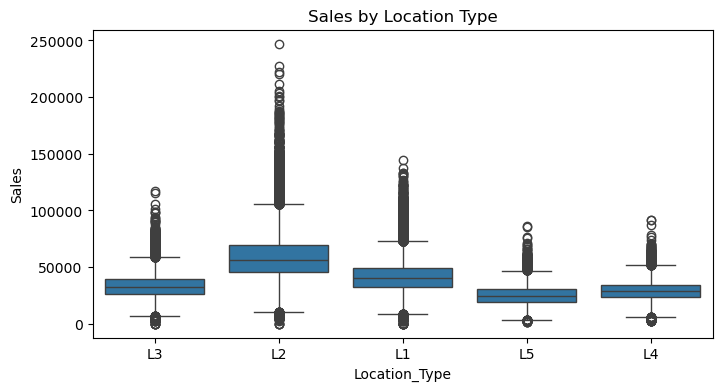

In [10]:
# Boxplot: Sales by Location Type
plt.figure(figsize=(8, 4))
sns.boxplot(x="Location_Type", y="Sales", data=df)
plt.title("Sales by Location Type")
plt.show()

**This plot compares sales across different location types (urban, rural, etc.).**  
There appears to be variability based on location — some areas perform better than others.


### Hypothesis Test 1: Do Holidays Affect Sales?

- Null Hypothesis (H₀): Holidays do not affect sales.
- Alternate Hypothesis (H₁): Holidays affect sales.


In [13]:
# Re-load fresh
df_raw = pd.read_csv("TRAIN.csv")
print(df_raw['Holiday'].unique())


[1 0]


In [14]:
# Re-load fresh if needed
df = pd.read_csv("TRAIN.csv")

# Convert 'Date' column again if needed
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek


In [15]:
from scipy.stats import ttest_ind

# Group sales by holiday/non-holiday
sales_holiday = df[df['Holiday'] == 1]['Sales']
sales_nonholiday = df[df['Holiday'] == 0]['Sales']

# T-test
t_stat, p_val = ttest_ind(sales_holiday, sales_nonholiday, equal_var=False)

print(f"T-stat: {t_stat:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("✅ Holidays significantly affect sales.")
else:
    print("❌ Holidays do not significantly affect sales.")


T-stat: -66.18, p-value: 0.0000
✅ Holidays significantly affect sales.


### Hypothesis Test: Do Holidays Affect Sales?

- Null Hypothesis (H₀): Holidays do not impact sales.
- Alternate Hypothesis (H₁): Holidays affect sales.

We used a two-sample t-test to compare average sales on holidays vs non-holidays.

**Result:**  
- T-statistic = -66.18  
- p-value = 0.0000  
✅ We reject the null hypothesis. **Holidays significantly affect sales.**


In [17]:
# Start fresh
df_model = df.copy()

# Convert Date
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model['Month'] = df_model['Date'].dt.month
df_model['Day'] = df_model['Date'].dt.day
df_model['Weekday'] = df_model['Date'].dt.dayofweek

# Drop unusable column
df_model = df_model.drop(columns=['Discount'])  # It's all NaN

# One-hot encode categorical columns
df_model = pd.get_dummies(df_model, columns=['Store_Type', 'Location_Type', 'Region_Code'], drop_first=True)

# Drop ID, Store_id, and Date (not useful)
df_model = df_model.drop(columns=['ID', 'Store_id', 'Date'])

# Final check
print("Final dataset shape:", df_model.shape)
print(df_model.columns)


Final dataset shape: (188340, 16)
Index(['Holiday', '#Order', 'Sales', 'Month', 'Day', 'Weekday',
       'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L2',
       'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
       'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4'],
      dtype='object')





**Let’s move to Model Training & Evaluation**
We’ll train:

Linear Regression (baseline)

XGBoost Regressor (stronger model)

Compare their performance using MAE, RMSE, and R²

In [19]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['Sales'])
y = df_model['Sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)


Training shape: (150672, 15)


**Linear Regression**

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n📉 Linear Regression Performance:")
print(f"MAE  = {mae_lr:.2f}")
print(f"RMSE = {rmse_lr:.2f}")
print(f"R²   = {r2_lr:.4f}")



📉 Linear Regression Performance:
MAE  = 3915.78
RMSE = 5376.24
R²   = 0.9145


**XGBoost Regressor**

In [23]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n🚀 XGBoost Performance:")
print(f"MAE  = {mae_xgb:.2f}")
print(f"RMSE = {rmse_xgb:.2f}")
print(f"R²   = {r2_xgb:.4f}")



🚀 XGBoost Performance:
MAE  = 2483.62
RMSE = 3550.70
R²   = 0.9627


**Let’s save XGBoost model for deployment**

In [25]:
from xgboost import XGBRegressor
import joblib

# Train XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Save to binary .pkl
joblib.dump(xgb_model, 'best_sales_model.pkl')

['best_sales_model.pkl']

In [26]:
import joblib
from xgboost import Booster

# Load the old model
old_model = joblib.load('best_sales_model.pkl')

# Save using XGBoost's native format
old_model.save_model('best_sales_model.json')  # or .ubj, .bin

print("Model re-saved in XGBoost native format!")

Model re-saved in XGBoost native format!


In [43]:
# Create a simple, clean dataset for Tableau
tableau_df = df[['Date', 'Sales', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday', '#Order']].copy()

tableau_df['Date'] = pd.to_datetime(tableau_df['Date'])
tableau_df['Month'] = tableau_df['Date'].dt.month
tableau_df['Weekday'] = tableau_df['Date'].dt.dayofweek

# Save to CSV
tableau_df.to_csv("tableau_sales_data.csv", index=False)
print("✅ File saved: tableau_sales_data.csv")


✅ File saved: tableau_sales_data.csv
